## Home Credit Model and Submission

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, joblib
from pprint import pprint
import lightgbm as lgb
from sklearn import metrics
from functools import reduce
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedGroupKFold
from contextlib import suppress

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pathway = "/kaggle/input/home-credit-credit-risk-model-stability/"

def set_table_dtypes(df: pl.DataFrame)-> pl.DataFrame:
    for col in df.columns:
        # Cast Transform DPD (Days past due, P) and Transform Amount (A) as Float64
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        # Cast Transform date (D) as Date, causes issues with other columns ending in D
        #if col[-1] in ("D"):
            #df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
        # Cast aggregated columns as Float64, tried combining sum and max, but did not work correctly
        if col[-4:-1] in ('_sum'):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        if col[-4:-1] in ('_max'):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
    return df

def convert_strings(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
    return df

# Changed this function to work for Pandas
def missing_values(df, threshold = 0.0):
    for col in df.columns:
        decimal = (pd.isnull(test[col]).sum())/(len(test[col]))
        if decimal > threshold:                                         
            print(f"{col}: {decimal}")

# Impute numeric columns with the median and cat with mode
def imputer(df:pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype in ['float64']:
            df[col] = df[col].fillna(df[col].median())
        if df[col].dtype.name in ['category','object'] and df[col].isnull().any():
            mode_without_nan = df[col].dropna().mode().values[0]
            df[col] = df[col].fillna(mode_without_nan)
    return df

In [3]:
# Taken from other competition notebooks
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Generate joined test data 
#### Part 1
Preprocessed the training csvs in the same way, lists of columns that are dropped were manually taken from what was dropped in training based on excessive missing values. Used .drop(errors='ignore') to handle situations where hidden test set has different columns. 

In [4]:
test_basetable = pl.read_csv(pathway + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes)
    ], how="vertical_relaxed")
test_static_cb=pl.read_csv(pathway + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1=pl.read_csv(pathway +  "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2=pl.read_csv(pathway + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [5]:
# Additional depth=1 files
test_other_1 = pl.read_csv(pathway + "csv_files/test/test_other_1.csv").pipe(set_table_dtypes)

test_credit_bureau_b_1 = pl.read_csv(pathway + "csv_files/test/test_credit_bureau_b_1.csv").pipe(set_table_dtypes)

test_deposit_1 = pl.read_csv(pathway + "csv_files/test/test_deposit_1.csv").pipe(set_table_dtypes)

# test_debitcard_1 = pl.read_csv(pathway + "csv_files/test/test_debitcard_1.csv").pipe(set_table_dtypes)
test_basetable = test_basetable.with_columns(pl.col('date_decision').cast(pl.Date))

In [6]:
#use aggregation functions in tables with depth >=1

test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").sum().alias("mainoccupationinc_384A_sum"))

#num_group1=0 represents the person who applied for the loan
test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "incometype_1044T", "birth_259D",
    "empl_employedfrom_271D","empl_industry_691L","familystate_447L","sex_738L","type_25L",
    "safeguarantyflag_411L","empl_employedtotal_800L","role_1084L"]).filter(
    pl.col("num_group1")==0).drop("num_group1")

#we now have num_group1 and num_group2, so aggregate again
test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").sum().alias("pmts_pmtsoverdue_635A_sum"),
    pl.col("pmts_dpdvalue_108P").sum().alias("pmts_dpdvalue_108P_sum"))

In [7]:
# Additional aggregation for depth=1 files
test_other_1_feats = test_other_1.group_by("case_id").agg(
    pl.col("amtdebitincoming_4809443A").sum().alias("amtdebitincoming_4809443A_sum"),
    pl.col("amtdebitoutgoing_4809440A").sum().alias("amtdebitoutgoing_4809440A_sum"),
    pl.col("amtdepositbalance_4809441A").sum().alias("amtdepositbalance_4809441A_sum"),
    pl.col("amtdepositincoming_4809444A").sum().alias("amtdepositincoming_4809444A_sum"),
    pl.col("amtdepositoutgoing_4809442A").sum().alias("amtdepositoutgoing_4809442A_sum"))

test_credit_bureau_b_1_feats = test_credit_bureau_b_1.group_by("case_id").agg(
    pl.col("amount_1115A").sum().alias("amount_1115A_sum"),
    pl.col("credquantity_1099L").sum().alias("credquantity_1099L_sum"),
    pl.col("credquantity_984L").sum().alias("credquantity_984L_sum"),
    pl.col("debtpastduevalue_732A").sum().alias("debtpastduevalue_732A_sum"),
    pl.col("debtvalue_227A").sum().alias("debtvalue_227A_sum"),
    pl.col("dpd_550P").sum().alias("dpd_550P_sum"),
    pl.col("dpd_733P").sum().alias("dpd_733P_sum"),
    pl.col("dpdmax_851P").max().alias("dpdmax_851P_max"),
    pl.col("installmentamount_644A").sum().alias("installmentamount_644A_sum"),
    pl.col("installmentamount_833A").sum().alias("installmentamount_833A_sum"),
    pl.col("instlamount_892A").sum().alias("instlamount_892A_sum"),
    pl.col("interestrateyearly_538L").max().alias("interestrateyearly_538L_max"),
    pl.col("maxdebtpduevalodued_3940955A").max().alias("maxdebtpduevalodued_3940955A_max"),
    pl.col("numberofinstls_810L").sum().alias("numberofinstls_810L_sum"),
    pl.col("overdueamountmax_950A").max().alias("overdueamountmax_950A_max"),
    pl.col("pmtdaysoverdue_1135P").sum().alias("pmtdaysoverdue_1135P_sum"),
    pl.col("pmtnumpending_403L").sum().alias("pmtnumpending_403L_sum"),
    pl.col("residualamount_3940956A").sum().alias("residualamount_3940956A_sum"),
    pl.col("totalamount_503A").sum().alias("totalamount_503A_sum"),
    pl.col("totalamount_881A").sum().alias("totalamount_881A_sum"))

test_deposit_1_feats = test_deposit_1.group_by("case_id").agg(
    pl.col("amount_416A").sum().alias("amount_416A_sum"))

In [8]:
# join all tables/columns together

join_data1 = test_basetable.join(test_static, how="left", on="case_id"
).join(test_static_cb, how="left", on="case_id"
).join(test_person_1_feats_1, how="left", on="case_id"
).join(test_person_1_feats_2, how="left", on="case_id"
).join(test_credit_bureau_b_2_feats, how="left", on="case_id"
).join(test_other_1_feats, how="left", on="case_id"
).join(test_credit_bureau_b_1_feats, how="left", on="case_id"
).join(test_deposit_1_feats, how="left", on="case_id"
)

In [9]:
# After merge, convert back to pandas for errors='ignore' functionality 
join_data1 = join_data1.to_pandas()
# Based on training preprocessing
drop_cols = ['clientscnt_136L', 'datelastinstal40dpd_247D', 'equalitydataagreement_891L', 'equalityempfrom_62L', 'interestrategrace_34L', 'isbidproductrequest_292L', 'lastdependentsnum_448L', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrepayingdate_696D', 'maxannuity_4075009A', 'payvacationpostpone_4187118D', 'validfrom_1069D', 'assignmentdate_238D', 'assignmentdate_4527235D', 'assignmentdate_4955616D', 'dateofbirth_342D', 'for3years_128L', 'for3years_504L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'formonth_535L', 'forquarter_1017L', 'forquarter_462L', 'forquarter_634L', 'fortoday_1092L', 'forweek_1077L', 'forweek_528L', 'forweek_601L', 'foryear_618L', 'foryear_818L', 'foryear_850L', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtcount_4527229L', 'pmtcount_4955617L', 'pmtcount_693L', 'riskassesment_302T', 'riskassesment_940T', 'pmts_pmtsoverdue_635A_sum', 'pmts_dpdvalue_108P_sum', 'amtdebitincoming_4809443A_sum', 'amtdebitoutgoing_4809440A_sum', 'amtdepositbalance_4809441A_sum', 'amtdepositincoming_4809444A_sum', 'amtdepositoutgoing_4809442A_sum', 'amount_1115A_sum', 'credquantity_1099L_sum', 'credquantity_984L_sum', 'debtpastduevalue_732A_sum', 'debtvalue_227A_sum', 'dpd_550P_sum', 'dpd_733P_sum', 'dpdmax_851P_max', 'installmentamount_644A_sum', 'installmentamount_833A_sum', 'instlamount_892A_sum', 'interestrateyearly_538L_max', 'maxdebtpduevalodued_3940955A_max', 'numberofinstls_810L_sum', 'overdueamountmax_950A_max', 'pmtdaysoverdue_1135P_sum', 'pmtnumpending_403L_sum', 'residualamount_3940956A_sum', 'totalamount_503A_sum', 'totalamount_881A_sum', 'amount_416A_sum']
join_data1 = join_data1.drop(drop_cols, axis=1, errors='ignore')
join_data1.shape

(10, 193)

In [10]:
del test_static, test_static_cb, test_person_1, test_credit_bureau_b_2, test_other_1,test_credit_bureau_b_1,test_deposit_1
del test_person_1_feats_1, test_person_1_feats_2, test_credit_bureau_b_2_feats, test_other_1_feats, test_credit_bureau_b_1_feats, test_deposit_1_feats   
gc.collect()  

0

#### Part 2

In [11]:
# Additional testing data, depth = 1
test_applprev_1 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_applprev_1_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_applprev_1_1.csv").pipe(set_table_dtypes) 
    ], how="vertical_relaxed")

test_tax_registry_a_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_a_1.csv").pipe(set_table_dtypes)
test_tax_registry_b_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_b_1.csv").pipe(set_table_dtypes)    
test_tax_registry_c_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_c_1.csv").pipe(set_table_dtypes)
    
test_credit_bureau_a_1 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_1.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_2.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_3.csv").pipe(set_table_dtypes),
    ], how="vertical_relaxed")

In [12]:
selection = ['credacc_actualbalance_314A', 'credacc_maxhisbal_375A', 'credacc_minhisbal_90A', 'credacc_status_367L', 'credacc_transactions_402L', 'isdebitcard_527L', 'revolvingaccount_394A']
test_applprev_1 = test_applprev_1.drop(selection)

selection = ['annualeffectiverate_199L', 'annualeffectiverate_63L', 'contractsum_5085717L', 'credlmt_230A', 'credlmt_935A', 'debtoutstand_525A', 'debtoverdue_47A', 'instlamount_768A', 'instlamount_852A', 'interestrate_508L', 'nominalrate_281L', 'numberofcontrsvalue_258L', 'numberofcontrsvalue_358L', 'numberofinstls_320L', 'numberofoutstandinstls_59L', 'numberofoverdueinstlmaxdat_641D', 'outstandingamount_362A', 'overdueamountmax2date_1142D', 'periodicityofpmts_837L', 'prolongationcount_1120L', 'prolongationcount_599L', 'residualamount_488A', 'residualamount_856A', 'totalamount_996A', 'totaldebtoverduevalue_178A', 'totaldebtoverduevalue_718A', 'totaloutstanddebtvalue_39A', 'totaloutstanddebtvalue_668A']
test_credit_bureau_a_1 = test_credit_bureau_a_1.drop(selection)

# Change L columns to float64
for col in test_credit_bureau_a_1.columns:
        if col[-1] in ("L"):
            test_credit_bureau_a_1 = test_credit_bureau_a_1.with_columns(pl.col(col).cast(pl.Float64).alias(col))

In [13]:
test_applprev_1_feats_1 = test_applprev_1.group_by("case_id").agg(
    pl.col("actualdpd_943P").sum().alias("actualdpd_943P_sum"),
    pl.col("annuity_853A").sum().alias("annuity_853A_sum"),
    pl.col("byoccupationinc_3656910L").max().alias("byoccupationinc_3656910L_max"),
    pl.col("childnum_21L").max().alias("childnum_21L_max"),
    pl.col("credacc_credlmt_575A").max().alias("credacc_credlmt_575A_max"),
    pl.col("currdebt_94A").sum().alias("currdebt_94A_sum"),
    pl.col("downpmt_134A").sum().alias("downpmt_134A_sum"),
    pl.col("isbidproduct_390L").max(),
    pl.col("mainoccupationinc_437A").sum().alias("mainoccupationinc_437A_sum"),
    pl.col("maxdpdtolerance_577P").max().alias("maxdpdtolerance_577P_max"),
    pl.col("outstandingdebt_522A").sum().alias("outstandingdebt_522A_sum"),
    pl.col("pmtnum_8L").sum().alias("pmtnum_8L_sum"),
    pl.col("tenor_203L").sum().alias("tenor_203L_sum"))

test_applprev_1_feats_2 = test_applprev_1.select(["case_id", "num_group1",
    "credtype_587L","familystate_726L","inittransactioncode_279L","status_219L"]).filter(
    pl.col("num_group1")==0).drop("num_group1")

test_tax_registry_a_1_feats = test_tax_registry_a_1.group_by("case_id").agg(
    pl.col("amount_4527230A").sum().alias("amount_4527230A_sum"))

test_tax_registry_b_1_feats = test_tax_registry_b_1.group_by("case_id").agg(
    pl.col("amount_4917619A").sum().alias("amount_4917619A_sum"))

test_tax_registry_c_1_feats = test_tax_registry_c_1.group_by("case_id").agg(
    pl.col("pmtamount_36A").sum().alias("pmtamount_36A_sum"))

In [14]:
test_credit_bureau_a_1_feats = test_credit_bureau_a_1.group_by("case_id").agg(
    pl.col("dpdmax_139P").max().alias("dpdmax_139P_max"),
    pl.col("dpdmax_757P").max().alias("dpdmax_757P_max"),
    pl.col("monthlyinstlamount_332A").sum().alias("monthlyinstlamount_332A_sum"),
    pl.col("monthlyinstlamount_674A").sum().alias("monthlyinstlamount_674A_sum"),
    pl.col("nominalrate_498L").max().alias("nominalrate_498L_max"),
    pl.col("numberofinstls_229L").sum().alias("numberofinstls_229L_sum"),
    pl.col("numberofoutstandinstls_520L").sum().alias("numberofoutstandinstls_520L_sum"),
    pl.col("numberofoverdueinstlmax_1039L").sum().alias("numberofoverdueinstlmax_1039L_sum"),
    pl.col("numberofoverdueinstlmax_1151L").sum().alias("numberofoverdueinstlmax_1151L_sum"),
    pl.col("numberofoverdueinstls_725L").sum().alias("numberofoverdueinstls_725L_sum"),
    pl.col("numberofoverdueinstls_834L").sum().alias("numberofoverdueinstls_834L_sum"),
    pl.col("outstandingamount_354A").sum().alias("outstandingamount_354A_sum"),
    pl.col("overdueamount_31A").sum().alias("overdueamount_31A_sum"),
    pl.col("overdueamount_659A").sum().alias("overdueamount_659A_sum"),
    pl.col("overdueamountmax2_14A").max().alias("overdueamountmax2_14A_max"),
    pl.col("overdueamountmax2_398A").max().alias("overdueamountmax2_398A_max"),
    pl.col("overdueamountmax_155A").max().alias("overdueamountmax_155A_max"),
    pl.col("overdueamountmax_35A").max().alias("overdueamountmax_35A_max"),
    pl.col("periodicityofpmts_1102L").max().alias("periodicityofpmts_1102L_max"),
    pl.col("totalamount_6A").sum().alias("totalamount_6A_sum"))

test_tax_registry_c_1_feats= test_tax_registry_c_1_feats.with_columns(pl.col('case_id').cast(pl.Int64))

In [15]:
join_data2 = test_basetable.join(test_applprev_1_feats_1, how="left", on="case_id"
).join(test_applprev_1_feats_2, how="left", on="case_id"
).join(test_tax_registry_a_1_feats, how="left", on="case_id"
).join(test_tax_registry_b_1_feats, how="left", on="case_id"
).join(test_tax_registry_c_1_feats, how="left", on="case_id"
).join(test_credit_bureau_a_1_feats, how="left", on="case_id")

join_data2=join_data2.to_pandas()

drop_cols = ['date_decision','MONTH','WEEK_NUM','amount_4917619A_sum']
join_data2 = join_data2.drop(drop_cols, axis=1, errors='ignore')
join_data2.shape

(10, 40)

In [16]:
del test_applprev_1, test_tax_registry_a_1, test_tax_registry_b_1, test_tax_registry_c_1,test_credit_bureau_a_1
del test_applprev_1_feats_1, test_applprev_1_feats_2, test_tax_registry_a_1_feats, test_tax_registry_b_1_feats, test_tax_registry_c_1_feats, test_credit_bureau_a_1_feats
gc.collect()

0

#### Part 3

In [17]:
# Additional testing data, depth = 2
test_applprev_2 = pl.read_csv(pathway + "csv_files/test/test_applprev_2.csv").pipe(set_table_dtypes)

test_person_2 = pl.read_csv(pathway + "csv_files/test/test_person_2.csv").pipe(set_table_dtypes)


In [18]:
sel = ['case_id','num_group1','num_group2','pmts_dpd_1073P','pmts_dpd_303P','pmts_overdue_1140A','pmts_overdue_1152A']
test_credit_bureau_a_2 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_0.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_1.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_2.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_3.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_4.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_5.csv",columns=sel).pipe(set_table_dtypes)
    ], how="vertical_relaxed")

test_credit_bureau_a_21 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_6.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_7.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_8.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_9.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_10.csv",columns=sel).pipe(set_table_dtypes)
    ], how="vertical_relaxed")

In [19]:
test_applprev_2_feats = test_applprev_2.select(["case_id", "num_group1", "num_group2",
    "conts_type_509L"]).filter(
    (pl.col("num_group1")==0) & (pl.col("num_group2")==0)).drop("num_group1").drop("num_group2") 

test_credit_bureau_a_2_feats = test_credit_bureau_a_2.group_by("case_id").agg(
    pl.col("pmts_dpd_1073P").sum().alias("pmts_dpd_1073P_sum"),
    pl.col("pmts_dpd_303P").sum().alias("pmts_dpd_303P_sum"),
    pl.col("pmts_overdue_1140A").sum().alias("pmts_overdue_1140A_sum"),
    pl.col("pmts_overdue_1152A").sum().alias("pmts_overdue_1152A_sum"))

test_credit_bureau_a_21_feats = test_credit_bureau_a_21.group_by("case_id").agg(
    pl.col("pmts_dpd_1073P").sum().alias("pmts_dpd_1073P_sum"),
    pl.col("pmts_dpd_303P").sum().alias("pmts_dpd_303P_sum"),
    pl.col("pmts_overdue_1140A").sum().alias("pmts_overdue_1140A_sum"),
    pl.col("pmts_overdue_1152A").sum().alias("pmts_overdue_1152A_sum"))

test_person_2_feats = test_person_2.select(["case_id", "num_group1", "num_group2", "addres_zip_823M",
    "addres_district_368M","conts_role_79M","empls_economicalst_849M","empls_employer_name_740M"]).filter(
    (pl.col("num_group1")==0) & (pl.col("num_group2")==0)).drop("num_group1").drop("num_group2")

In [20]:
join_data3 = test_basetable.join(test_applprev_2_feats, how="left", on="case_id"
).join(test_credit_bureau_a_2_feats, how="left", on="case_id").join(test_credit_bureau_a_21_feats, how="left", on="case_id").join(test_person_2_feats, how="left", on="case_id")

join_data3 = join_data3.to_pandas()
join_data3 = join_data3.drop(['date_decision','MONTH','WEEK_NUM'], axis=1, errors='ignore')

In [21]:
del test_applprev_2, test_person_2, test_credit_bureau_a_2,test_credit_bureau_a_21
del test_applprev_2_feats, test_credit_bureau_a_2_feats, test_person_2_feats, test_credit_bureau_a_21_feats
gc.collect()

0

In [22]:
dfs = [join_data1, join_data2, join_data3]
join_test = reduce(lambda left, right: pd.merge(left, right, on='case_id'), dfs)

# Convert back to polars for datetime 
join_test = pl.from_pandas(join_test)

In [23]:
join_test.head()

case_id,date_decision,MONTH,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,…,status_219L,amount_4527230A_sum,pmtamount_36A_sum,dpdmax_139P_max,dpdmax_757P_max,monthlyinstlamount_332A_sum,monthlyinstlamount_674A_sum,nominalrate_498L_max,numberofinstls_229L_sum,numberofoutstandinstls_520L_sum,numberofoverdueinstlmax_1039L_sum,numberofoverdueinstlmax_1151L_sum,numberofoverdueinstls_725L_sum,numberofoverdueinstls_834L_sum,outstandingamount_354A_sum,overdueamount_31A_sum,overdueamount_659A_sum,overdueamountmax2_14A_max,overdueamountmax2_398A_max,overdueamountmax_155A_max,overdueamountmax_35A_max,periodicityofpmts_1102L_max,totalamount_6A_sum,conts_type_509L,pmts_dpd_1073P_sum,pmts_dpd_303P_sum,pmts_overdue_1140A_sum,pmts_overdue_1152A_sum,pmts_dpd_1073P_sum_right,pmts_dpd_303P_sum_right,pmts_overdue_1140A_sum_right,pmts_overdue_1152A_sum_right,addres_zip_823M,addres_district_368M,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M
i64,datetime[ns],i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str
57543,2021-05-14 00:00:00,202201,100,0.0,191767.36,3674.6,1218.2001,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,1.0,1.0,16049.4,17054.4,2.0,14554.4,24482.0,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""K""",null,null,0.0,20.0,5943.6001,55337.1182,42.5,91.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,3271.6882,0.0,3271.6882,30.0,157804.2,"""PRIMARY_MOBILE…",0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null
57549,2022-01-17 00:00:00,202201,100,0.0,129704.4,5742.6,3546.6,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,-1.0,0.0,32426.201,118964.805,0.0,13681.714,32426.201,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,0.0,108.0,21177.2,45590.202,657.0,7.0,0.0,0.0,310.0,0.0,0.0,0.0,0.0,0.0,0.0,48690.402,0.0,48690.402,30.0,492000.0,null,null,null,null,null,0.0,0.0,0.0,0.0,null,null,null,null,null
57551,2020-11-27 00:00:00,202201,100,0.0,71036.4,2844.6,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.0,null,-1.0,1.0,8357.2,null,1.0,0.0,9551.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,0.0,3.0,32864.728,32940.439,31.0,172.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10429.616,0.0,10429.616,30.0,903801.23,null,0.0,0.0,0.0,0.0,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1"""
57552,2020-11-27 00:00:00,202201,100,0.0,183992.0,6298.8003,12155.4,0.0,0.0,0.0,0.0,0.0,9.0,-9.0,-7.0,-9.0,0.0,7440.4,null,0.0,199322.4,9148.4,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1"""
57569,2021-12-20 00:00:00,202201,100,0.0,0.0,4682.6,0.0,0.0,1.0,0.0,0.0,0.0,6.0,2824.0,null,2824.0,2517.0,null,null,null,null,10796.4,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,16300.0,0.0,233424.814,null,null,null,null,"""P96_113

## Final Join Test Data

In [24]:
test = join_test.with_columns(pl.col('date_decision').cast(pl.Date))
# Feature engineer date columns
date_list = ['datefirstoffer_1144D', 'datelastunpaid_3546854D', 'dtlastpmtallstes_4499206D', 'firstclxcampaign_1125D', 'lastdelinqdate_224D', 'lastrejectdate_50D', 'maxdpdinstldate_3546855D', 'birthdate_574D', 'responsedate_1012D', 'responsedate_4527233D', 'responsedate_4917613D', 'empl_employedfrom_271D',
            'firstdatedue_489D','lastactivateddate_801D','lastapplicationdate_877D', 'lastapprdate_640D', 'dateofbirth_337D','birth_259D']

for col in date_list:
    test = test.with_columns(pl.col(col).cast(pl.Date))
    test = test.with_columns(
        ((pl.col("date_decision") - pl.col(col)) / (24 * 60 * 60 * 1000)).cast(pl.Float64).alias(f"{col}_diff"))

test = test.pipe(set_table_dtypes).pipe(convert_strings)

drop_list = ['date_decision','MONTH'] + date_list
# Convert to pandas for drop(errors='ignore')
test = test.to_pandas()
test = test.drop(drop_list, axis=1, errors='ignore')

del join_data1, join_data2, join_data3, join_test, dfs
gc.collect()

test.shape

(10, 244)

In [25]:
# Noticed some of these numeric variables were parsed as strings, changed them all to int 
num_list = ['numinstlswithdpd5_4187116L', 'numinstmatpaidtearly2d_4499204L','numinstpaid_4499208L','numinstpaidearly3dest_4493216L','numinstpaidearly5dest_4493211L',
           'numinstpaidearly5dobd_4499205L','numinstpaidearlyest_4493214L','numinstpaidlastcontr_4325080L','numinstregularpaidest_4493210L','numinsttopaygrest_4493213L','numinstunpaidmaxest_4493212L',
           'contractssum_5085716L','days120_123L','days180_256L','days360_512L','firstquarter_103L','fourthquarter_440L','numberofqueries_373L','pmtscount_423L','secondquarter_766L','thirdquarter_1082L',
           'days30_165L','days90_310L']
for col in num_list:
    test[col]=test[col].astype('float64')

In [26]:
# Same as training preprocessing
drop_list = ['lastapprcommoditytypec_5251766M', 'lastrejectcommodtypec_5251769M','lastrejectcommoditycat_161M','lastrejectreasonclient_4145040M',
            'previouscontdistrict_112M','lastapprcommoditycat_1041M', 'lastcancelreason_561M','lastrejectreason_759M','commnoinclast6m_3546845L', 'deferredmnthsnum_166L', 'mastercontrelectronic_519L', 'mastercontrexist_109L',
            'bankacctype_710L','cardtype_51L','isdebitcard_729L','lastapprcommoditytypec_5251766M','lastrejectcommodtypec_5251769M','opencred_647L','paytype1st_925L','paytype_783L',
            'twobodfilling_608L','typesuite_864L','education_88M','maritalst_893M','type_25L','safeguarantyflag_411L','addres_zip_823M','addres_district_368M','conts_role_79M','empls_economicalst_849M','empls_employer_name_740M']
test.drop(columns=drop_list,axis=1,errors='ignore',inplace=True)
# Drop rows with all na
test.dropna(axis=1, how='all', inplace=True)
test.head()

,case_id,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,lastrejectdate_50D_diff,maxdpdinstldate_3546855D_diff,responsedate_4917613D_diff,empl_employedfrom_271D_diff,firstdatedue_489D_diff,lastactivateddate_801D_diff,lastapplicationdate_877D_diff,lastapprdate_640D_diff,dateofbirth_337D_diff,birth_259D_diff
0,57543,100,0.0,191767.36,3674.6000,1218.2001,0.0,0.0,0.0,0.0,...,2100.0,62.0,-14.0,NaN,3398.0,18.0,41.0,41.0,14804.0,14804.0
1,57549,100,0.0,129704.40,5742.6000,3546.6000,0.0,2.0,0.0,0.0,...,-10.0,1897.0,-14.0,NaN,4035.0,-10.0,-10.0,4.0,22723.0,22723.0
2,57551,100,0.0,71036.40,2844.6000,0.0000,0.0,1.0,0.0,0.0,...,NaN,211.0,-14.0,6898.0,394.0,405.0,14.0,9.0,14090.0,14090.0
3,57552,100,0.0,183992.00,6298.8003,12155.4000,0.0,0.0,0.0,0.0,...,80.0,NaN,-14.0,NaN,685.0,234.0,80.0,240.0,23768.0,23768.0
4,57569,100,0.0,0.00,4682.6000,0.0000,0.0,1.0,0.0,0.0,...,21.0,3375.0,-14.0,NaN,3574.0,3440.0,-14.0,-14.0,26408.0,26408.0


#### Imputation

In [27]:

print(np.count_nonzero(test.isnull()))
# Impute missing values, 0 missing values after imputation
test = imputer(test)
print(np.count_nonzero(test.isnull()))


569
0


/tmp/ipykernel_28/4288183837.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode_without_nan)


In [28]:
# See boolean columns
bool_cols = test.select_dtypes(include=['bool']).columns.tolist()
# Convert boolean columns to 0 or 1 (False or True)
for col in bool_cols:
    test[col] = test[col].astype(int)
# Check unique values of bool_cols
for col in bool_cols:
    print(test[col].unique())

[1 0]
[0 1]


In [29]:
# Verify dtypes are correct
#pd.set_option('display.max_rows', None)
#test.dtypes

In [30]:
cat_cols = test.select_dtypes(include=['category', 'object']).columns.tolist()
# Create dummies for all cat columns, not dropping first to keep column names same as training
test = pd.get_dummies(test, dtype=int, columns=cat_cols, sparse=True, drop_first=False)
test.head()

,case_id,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,incometype_1044T_RETIRED_PENSIONER,familystate_447L_SINGLE,sex_738L_F,sex_738L_M,role_1084L_CL,credtype_587L_CAL,familystate_726L_SINGLE,inittransactioncode_279L_CASH,status_219L_K,conts_type_509L_PRIMARY_MOBILE
0,57543,100,0.0,191767.36,3674.6000,1218.2001,0.0,0.0,0.0,0.0,...,0,1,1,0,1,1,1,1,1,1
1,57549,100,0.0,129704.40,5742.6000,3546.6000,0.0,2.0,0.0,0.0,...,1,1,1,0,1,1,1,1,1,1
2,57551,100,0.0,71036.40,2844.6000,0.0000,0.0,1.0,0.0,0.0,...,0,1,1,0,1,1,1,1,1,1
3,57552,100,0.0,183992.00,6298.8003,12155.4000,0.0,0.0,0.0,0.0,...,1,1,0,1,1,1,1,1,1,1
4,57569,100,0.0,0.00,4682.6000,0.0000,0.0,1.0,0.0,0.0,...,1,1,1,0,1,1,1,1,1,1


In [31]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.00 MB
Decreased by 70.4%


## Training Model

In [32]:
train = pl.read_csv('/kaggle/input/training/train_dummy305_withimpute.csv').pipe(set_table_dtypes).pipe(convert_strings)
train.head()

case_id,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,…,empl_employedtotal_800L_MORE_FIVE,empl_employedtotal_800L_LESS_ONE,empl_employedtotal_800L_MORE_ONE,role_1084L_CL,role_1084L_EM,isbidproduct_390L_False,isbidproduct_390L_True,credtype_587L_CAL,credtype_587L_COL,credtype_587L_REL,familystate_726L_SINGLE,familystate_726L_MARRIED,familystate_726L_WIDOWED,familystate_726L_DIVORCED,familystate_726L_LIVING_WITH_PARTNER,inittransactioncode_279L_CASH,inittransactioncode_279L_POS,inittransactioncode_279L_NDF,status_219L_D,status_219L_T,status_219L_A,status_219L_K,status_219L_N,status_219L_S,status_219L_Q,status_219L_L,status_219L_H,status_219L_R,status_219L_P,conts_type_509L_PRIMARY_MOBILE,conts_type_509L_PHONE,conts_type_509L_EMPLOYMENT_PHONE,conts_type_509L_HOME_PHONE,conts_type_509L_SECONDARY_MOBILE,conts_type_509L_PRIMARY_EMAIL,conts_type_509L_ALTERNATIVE_PHONE,conts_type_509L_WHATSAPP
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64
0,0,0,0.0,29758.396,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4,0.0,22754.5915,4417.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0.0
1,0,0,0.0,29758.396,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4,0.0,22754.5915,4417.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0.0
2,0,0,0.0,29758.396,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4,0.0,22754.5915,4417.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0.0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0.0
3,0,0,0.0,29758.396,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,1.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4,0.0,22754.5915,4417.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0.0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0.0
4,0,1,0.0,29758.396,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4,0.0,22754.5915,4417.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0.0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0.0


In [33]:
# Convert polars df to pandas so pandas specific methods/attributes work later, seems more memory efficient to load as pl and convert to pd than load as pd
train = train.to_pandas()
# Get list of ids for submission file
ids = test['case_id'].tolist()

In [34]:
# train is already dummified so make sure all cols are numeric
convert_cols = train.select_dtypes(include=['category', 'object']).columns.tolist()
for col in convert_cols:
    train[col]= pd.to_numeric(train[col])
train.shape

(1526659, 305)

In [35]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3552.48 MB
Memory usage after optimization is: 899.77 MB
Decreased by 74.7%


In [36]:
#pd.set_option('display.max_rows', None)
#train.dtypes

In [37]:
# Only select common columns to use
common_columns = list(set(train.columns) & set(test.columns))

test=test[common_columns]

# Subset train with only columns seen in test + target
train = train[common_columns+['target']]
train.shape

(1526659, 214)

In [38]:
"""
# Fit on stratified sample
# Note: no random seed, warning message is fine
train_sample = train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.01)).reset_index(drop=True)
train_sample.head()
"""

"\n# Fit on stratified sample\n# Note: no random seed, warning message is fine\ntrain_sample = train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.01)).reset_index(drop=True)\ntrain_sample.head()\n"

In [39]:
y = train.loc[:,'target'].to_frame('target')
X = train.drop(['target',], axis=1)

In [40]:
# Check target distribution is same after all the preprocessing/sampling
print(round(y.target.value_counts()[1]/y.target.value_counts().sum(),4))

0.0314


In [41]:
del train
gc.collect()

0

In [42]:
# Do not include case_id, or week_num as numeric 
numeric_cols = test.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('case_id')
numeric_cols.remove('WEEK_NUM')
#print(numeric_cols)

In [43]:
warnings.filterwarnings("ignore")
scaler = MinMaxScaler(copy=False)
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])
warnings.filterwarnings("default")

X.head()

,applicationscnt_464L,overdueamountmax_35A_max,avgdbddpdlast24m_3658932P,firstquarter_103L,sumoutstandtotal_3546847A,numcontrs3months_479L,numberofoverdueinstlmax_1039L_sum,maxdpdlast3m_392P,lastst_736L_T,clientscnt_304L,...,sex_738L_M,maxdpdlast24m_143P,maxoutstandbalancel12m_4187113A,numinstmatpaidtearly2d_4499204L,totinstallast1m_4525188A,monthlyinstlamount_332A_sum,numberofoverdueinstls_725L_sum,clientscnt_493L,dpdmax_139P_max,WEEK_NUM
0,0.000000,0.000005,0.203449,0.026316,0.020267,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.864817,0.037464,0.007826,0.00003,0.0,0.0,0.0,0
1,0.000000,0.000005,0.203449,0.026316,0.020267,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.864817,0.037464,0.007826,0.00003,0.0,0.0,0.0,0
2,0.000000,0.000005,0.203449,0.026316,0.020267,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.864817,0.037464,0.007826,0.00003,0.0,0.0,0.0,0
3,0.008097,0.000005,0.203449,0.026316,0.020267,0.017241,0.0,0.0,0.0,0.0,...,0.0,0.0,0.864817,0.037464,0.007826,0.00003,0.0,0.0,0.0,0
4,0.000000,0.000005,0.203449,0.026316,0.020267,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.864817,0.037464,0.007826,0.00003,0.0,0.0,0.0,0


## Models

In [44]:
# Drop case_id and week_num from features
weeks = X["WEEK_NUM"]
X_feats = X.drop(['case_id', 'WEEK_NUM'], axis=1)

# Sort columns in alphabetical order for training so columns match test submission
X_feats = X_feats.reindex(sorted(X_feats.columns), axis=1)

print(X_feats.shape)

(1526659, 211)


In [45]:
X_feats.head()

,actualdpd_943P_sum,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuity_853A_sum,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,sex_738L_M,status_219L_K,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,tenor_203L_sum,thirdquarter_1082L,totalamount_6A_sum,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A
0,0.0,0.0,0.021135,0.017340,0.023797,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.020267,0.02256,0.04,0.032258,0.000039,0.0,0.0,0.007826
1,0.0,0.0,0.021135,0.028824,0.023797,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,0.020267,0.02256,0.04,0.032258,0.000039,0.0,0.0,0.007826
2,0.0,0.0,0.021135,0.045845,0.004798,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.020267,0.02256,0.03,0.032258,0.000039,0.0,0.0,0.007826
3,0.0,0.0,0.021135,0.043075,0.012685,0.0,0.0,0.035714,0.0,0.008097,...,0.0,0.0,0.020267,0.02256,0.01,0.032258,0.000039,0.0,0.0,0.007826
4,0.0,0.0,0.021135,0.031243,0.005282,0.0,0.0,0.035714,0.0,0.000000,...,0.0,0.0,0.020267,0.02256,0.02,0.032258,0.000039,0.0,0.0,0.007826


In [46]:
del X
gc.collect()

0

In [47]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=5, shuffle=True)

fitted_models = []
cv_scores = []

# Note: uncomment device when running with GPU P100 accelerator
grid_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 2500,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "verbose": -1,
    "max_bin": 250,
    'device':'gpu',
}

for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
    X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
    
    clf = lgb.LGBMClassifier(**grid_params)
    clf.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
    fitted_models.append(clf)
    
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

warnings.filterwarnings("default")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.836465
[400]	valid_0's auc: 0.841524
[600]	valid_0's auc: 0.843416
[800]	valid_0's auc: 0.844404
[1000]	valid_0's auc: 0.844896
[1200]	valid_0's auc: 0.845078
[1400]	valid_0's auc: 0.84524
[1600]	valid_0's auc: 0.845342
Early stopping, best iteration is:
[1572]	valid_0's auc: 0.84539
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.828985
[400]	valid_0's auc: 0.834592
[600]	valid_0's auc: 0.836822
[800]	valid_0's auc: 0.837973
[1000]	valid_0's auc: 0.838588
[1200]	valid_0's auc: 0.839014
[1400]	valid_0's auc: 0.839222
Early stopping, best iteration is:
[1393]	valid_0's auc: 0.839243
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.833801
[400]	valid_0's auc: 0.838952
[600]	valid_0's auc: 0.84104
[800]	valid_0's auc: 0.841999
[1000]	valid_0's auc: 0.842326
[1200]	valid_0's auc: 0.842452
Early stopping, best iteration is:
[1141]	vali

In [48]:
# Set the best cv model
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)
model_plot = fitted_models[np.argmax(cv_scores)]

In [49]:
del fitted_models, cv_scores
gc.collect() 

43

## Metric Scoring

In [50]:
"""
warnings.filterwarnings("ignore")

base_train = pd.concat([X_train, y_train], axis=1)
base_train['score'] = grid_search.predict_proba(X_train_feats)[:,1]
print(f"The AUC score on the train set is: {roc_auc_score(base_train['target'], base_train['score'])}")

base_valid = pd.concat([X_valid, y_valid], axis=1)
base_valid['score'] = grid_search.predict_proba(X_valid_feats)[:,1]
print(f"The AUC score on the valid set is: {roc_auc_score(base_valid['target'], base_valid['score'])}")

warnings.filterwarnings('default')
"""

'\nwarnings.filterwarnings("ignore")\n\nbase_train = pd.concat([X_train, y_train], axis=1)\nbase_train[\'score\'] = grid_search.predict_proba(X_train_feats)[:,1]\nprint(f"The AUC score on the train set is: {roc_auc_score(base_train[\'target\'], base_train[\'score\'])}")\n\nbase_valid = pd.concat([X_valid, y_valid], axis=1)\nbase_valid[\'score\'] = grid_search.predict_proba(X_valid_feats)[:,1]\nprint(f"The AUC score on the valid set is: {roc_auc_score(base_valid[\'target\'], base_valid[\'score\'])}")\n\nwarnings.filterwarnings(\'default\')\n'

In [51]:
"""
# Taken from competition starter notebook made by one of the organizers 
# Note: may not work based on how we sampled a low percent of the data because some weeks will be all 0 targets
# Using 1 and 2% samples did not work
# Using 5% only worked for train, not for valid
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std
"""

'\n# Taken from competition starter notebook made by one of the organizers \n# Note: may not work based on how we sampled a low percent of the data because some weeks will be all 0 targets\n# Using 1 and 2% samples did not work\n# Using 5% only worked for train, not for valid\ndef gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):\n    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]        .sort_values("WEEK_NUM")        .groupby("WEEK_NUM")[["target", "score"]]        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()\n    \n    x = np.arange(len(gini_in_time))\n    y = gini_in_time\n    a, b = np.polyfit(x, y, 1)\n    y_hat = a*x + b\n    residuals = y - y_hat\n    res_std = np.std(residuals)\n    avg_gini = np.mean(gini_in_time)\n    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std\n'

In [52]:
"""
warnings.filterwarnings("ignore")
# supress lets the notebook run even if there is an exception thrown here from the sampling
with suppress(Exception):
    stability_score_train = gini_stability(base_train)
    print(f'The stability score on the train set is: {stability_score_train}') 

warnings.filterwarnings("default")
"""

'\nwarnings.filterwarnings("ignore")\n# supress lets the notebook run even if there is an exception thrown here from the sampling\nwith suppress(Exception):\n    stability_score_train = gini_stability(base_train)\n    print(f\'The stability score on the train set is: {stability_score_train}\') \n\nwarnings.filterwarnings("default")\n'

In [53]:
"""
warnings.filterwarnings("ignore")

with suppress(Exception):
    stability_score_valid = gini_stability(base_valid)
    print(f'The stability score on the valid set is: {stability_score_valid}') 

warnings.filterwarnings("default")
"""

'\nwarnings.filterwarnings("ignore")\n\nwith suppress(Exception):\n    stability_score_valid = gini_stability(base_valid)\n    print(f\'The stability score on the valid set is: {stability_score_valid}\') \n\nwarnings.filterwarnings("default")\n'

In [54]:
features = X_feats.columns
length = len(X_feats.columns)

del X_feats, X_train, X_valid, y_train, y_valid, y
gc.collect()

0

## Feature Importance

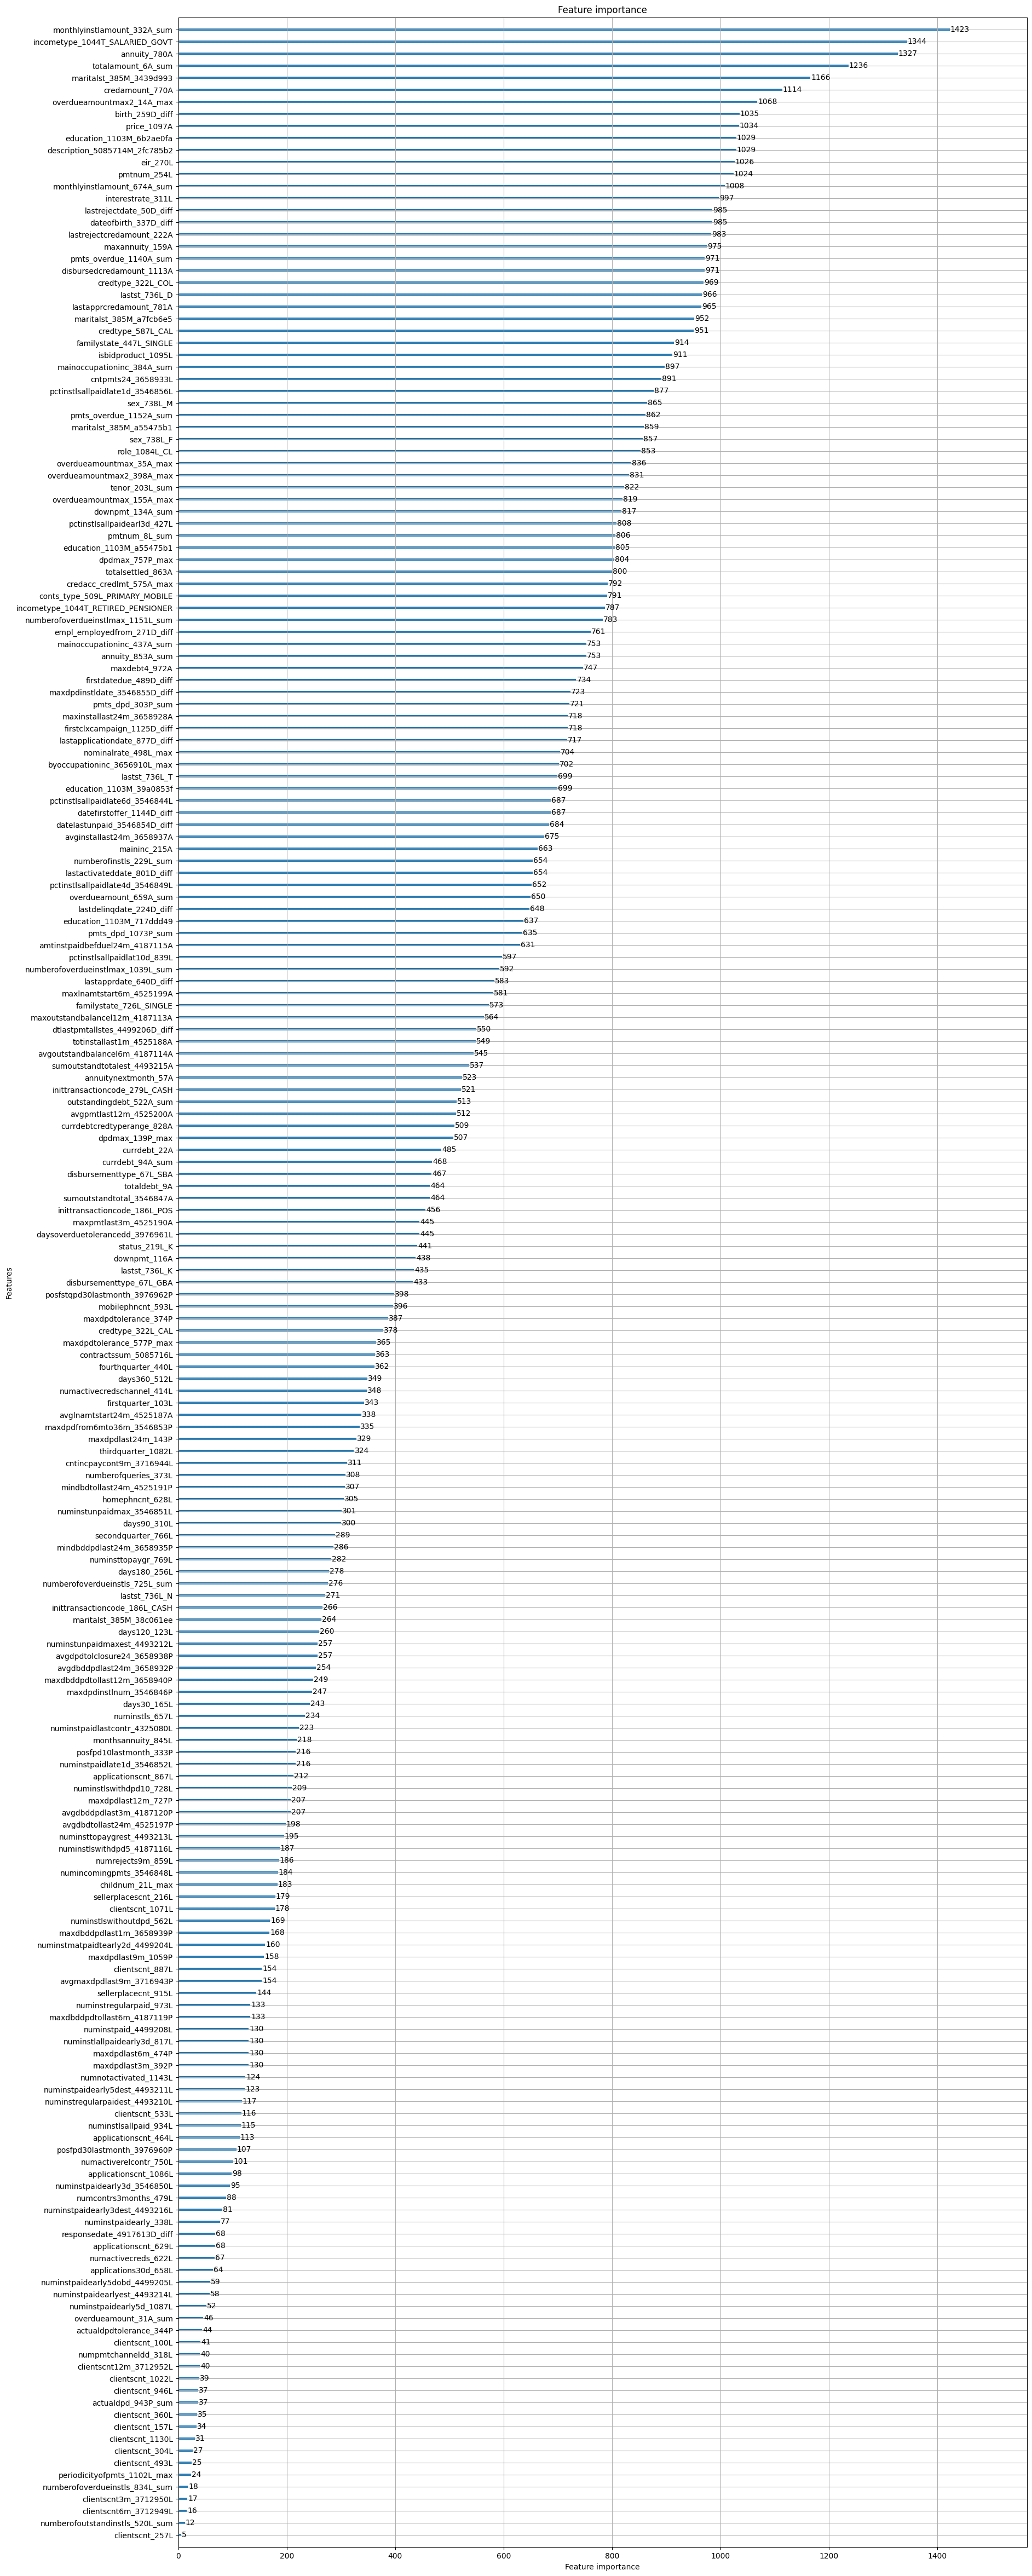

In [55]:
# For lgb model, does not work with VotingModel Class
lgb.plot_importance(model_plot, figsize=(20,60))
plt.show()

In [56]:
"""
# Get list of least important features
importances = model_plot.feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance']<100:
        drop_list.append(f['features'])
print(f"Number of original features: {length}")     
print(f"Number of features which are not important: {len(drop_list)}")
print(drop_list)
"""

'\n# Get list of least important features\nimportances = model_plot.feature_importances_\nfeature_importance = pd.DataFrame({\'importance\':importances,\'features\':features}).sort_values(\'importance\', ascending=False).reset_index(drop=True)\nfeature_importance\n\ndrop_list = []\nfor i, f in feature_importance.iterrows():\n    if f[\'importance\']<100:\n        drop_list.append(f[\'features\'])\nprint(f"Number of original features: {length}")     \nprint(f"Number of features which are not important: {len(drop_list)}")\nprint(drop_list)\n'

## Submission
to do: .

In [57]:
# Sort columns alphabetically to match loaded model
test = test.reindex(sorted(test.columns), axis=1)

predictions = model.predict_proba(test.drop(['case_id', 'WEEK_NUM'], axis=1))
print(predictions)

[[9.92526482e-01 7.47351814e-03]
 [9.88901801e-01 1.10981988e-02]
 [9.98724853e-01 1.27514684e-03]
 [9.95698294e-01 4.30170604e-03]
 [9.54814881e-01 4.51851189e-02]
 [9.98339995e-01 1.66000537e-03]
 [9.98917168e-01 1.08283222e-03]
 [9.99730491e-01 2.69508789e-04]
 [9.96218270e-01 3.78172988e-03]
 [9.99022897e-01 9.77103188e-04]]


In [58]:
del test
gc.collect()

49897

In [59]:
submission = pd.DataFrame({'case_id': ids, 'score': predictions[:,1]}).set_index('case_id')
submission

,score
case_id,
57543,0.007474
57549,0.011098
57551,0.001275
57552,0.004302
57569,0.045185
57630,0.001660
57631,0.001083
57632,0.000270
57633,0.003782


In [60]:
submission.to_csv("./submission.csv")